In [3]:
# Install required libraries
!pip install librosa soundfile matplotlib seaborn scikit-learn tensorflow

In [4]:
# Import libraries
import os
import librosa
import librosa.display
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import soundfile as sf

from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder
from sklearn.metrics import confusion_matrix, classification_report

import tensorflow as tf
from tensorflow.keras import layers, models, callbacks


In [5]:
from google.colab import files
files.upload()  # Upload kaggle.json


Saving kaggle.json to kaggle.json


{'kaggle.json': b'{"username":"tasminehnadaf","key":"217796a8dcaa257a774f62d71285a63c"}'}

In [6]:
# Move kaggle.json to the correct folder
!mkdir -p ~/.kaggle
!cp kaggle.json ~/.kaggle/
!chmod 600 ~/.kaggle/kaggle.json


In [7]:
# Install kaggle CLI if not already installed
!pip install -q kaggle


In [8]:
# Download the bird song dataset
!kaggle datasets download -d vinayshanbhag/bird-song-data-set


Dataset URL: https://www.kaggle.com/datasets/vinayshanbhag/bird-song-data-set
License(s): other
100% 2.08G/2.09G [00:32<00:00, 359MB/s]
100% 2.09G/2.09G [00:32<00:00, 68.0MB/s]


In [9]:
!unzip -o -q bird-song-data-set.zip -d bird_song_dataset

In [10]:
# Set path to unzipped dataset
DATASET_PATH = '/content/bird_song_dataset'


In [11]:
# Constants
SR = 22050           # Sample rate
DURATION = 5         # In seconds
SAMPLES_PER_TRACK = SR * DURATION

def load_audio(file_path, sr=SR, duration=DURATION):
    y, _ = librosa.load(file_path, sr=sr, duration=duration, mono=True)
    if len(y) < SAMPLES_PER_TRACK:
        padding = SAMPLES_PER_TRACK - len(y)
        y = np.pad(y, (0, padding))
    else:
        y = y[:SAMPLES_PER_TRACK]
    return y


In [12]:
def extract_mel_spectrogram(y, sr=SR, n_mels=128, hop_length=512):
    mel_spec = librosa.feature.melspectrogram(y=y, sr=sr, n_mels=n_mels, hop_length=hop_length)
    mel_spec_db = librosa.power_to_db(mel_spec, ref=np.max)
    return mel_spec_db

In [13]:
CSV_PATH = '/content/bird_song_dataset/bird_songs_metadata.csv'
AUDIO_DIR = '/content/bird_song_dataset/wavfiles'

In [14]:
df = pd.read_csv(CSV_PATH)
print(df.head())  # check the content and columns

       id       genus   species subspecies           name  \
0  557838  Thryomanes  bewickii        NaN  Bewick's Wren   
1  557838  Thryomanes  bewickii        NaN  Bewick's Wren   
2  557838  Thryomanes  bewickii        NaN  Bewick's Wren   
3  557838  Thryomanes  bewickii        NaN  Bewick's Wren   
4  557838  Thryomanes  bewickii        NaN  Bewick's Wren   

                recordist        country  \
0  Whitney Neufeld-Kaiser  United States   
1  Whitney Neufeld-Kaiser  United States   
2  Whitney Neufeld-Kaiser  United States   
3  Whitney Neufeld-Kaiser  United States   
4  Whitney Neufeld-Kaiser  United States   

                                  location  latitude  longitude altitude  \
0  Arlington, Snohomish County, Washington   48.0708  -122.1006      100   
1  Arlington, Snohomish County, Washington   48.0708  -122.1006      100   
2  Arlington, Snohomish County, Washington   48.0708  -122.1006      100   
3  Arlington, Snohomish County, Washington   48.0708  -122.1006 

In [15]:
import os
import numpy as np
import pandas as pd
import librosa
from sklearn.preprocessing import LabelEncoder
import tensorflow as tf

# Paths (adjust if needed)
AUDIO_DIR = '/content/bird_song_dataset/wavfiles'
CSV_PATH = '/content/bird_song_dataset/birds.csv'

# Constants
SR = 22050
DURATION = 5
SAMPLES_PER_TRACK = SR * DURATION

def load_audio(file_path, sr=SR, duration=DURATION):
    y, _ = librosa.load(file_path, sr=sr, duration=duration, mono=True)
    if len(y) < SAMPLES_PER_TRACK:
        y = np.pad(y, (0, SAMPLES_PER_TRACK - len(y)))
    else:
        y = y[:SAMPLES_PER_TRACK]
    return y

def extract_mel_spectrogram(y, sr=SR, n_mels=128, hop_length=512):
    mel_spec = librosa.feature.melspectrogram(y=y, sr=sr, n_mels=n_mels, hop_length=hop_length)
    mel_spec_db = librosa.power_to_db(mel_spec, ref=np.max)
    return mel_spec_db

# Load metadata CSV
df = pd.read_csv('/content/bird_song_dataset/bird_songs_metadata.csv')
print(df.head())

mel_specs = []
labels = []

for i, row in df.iterrows():
    filename = row['filename']
    label = row['species']
    file_path = os.path.join(AUDIO_DIR, filename)
    try:
        y = load_audio(file_path)
        mel_spec_db = extract_mel_spectrogram(y)
        # Normalize to [0,1]
        mel_spec_norm = (mel_spec_db - mel_spec_db.min()) / (mel_spec_db.max() - mel_spec_db.min())
        mel_spec_norm = mel_spec_norm[:, :216]  # trim/pad time dimension if necessary
        mel_specs.append(mel_spec_norm)
        labels.append(label)
    except Exception as e:
        print(f"Error processing {file_path}: {e}")

# Convert lists to arrays
X = np.array(mel_specs)
X = X[..., np.newaxis]  # Add channel dimension

# Encode labels
le = LabelEncoder()
y_encoded = le.fit_transform(labels)
y = tf.keras.utils.to_categorical(y_encoded, num_classes=len(le.classes_))

print(f"Features shape: {X.shape}")
print(f"Labels shape: {y.shape}")
print(f"Classes: {le.classes_}")


       id       genus   species subspecies           name  \
0  557838  Thryomanes  bewickii        NaN  Bewick's Wren   
1  557838  Thryomanes  bewickii        NaN  Bewick's Wren   
2  557838  Thryomanes  bewickii        NaN  Bewick's Wren   
3  557838  Thryomanes  bewickii        NaN  Bewick's Wren   
4  557838  Thryomanes  bewickii        NaN  Bewick's Wren   

                recordist        country  \
0  Whitney Neufeld-Kaiser  United States   
1  Whitney Neufeld-Kaiser  United States   
2  Whitney Neufeld-Kaiser  United States   
3  Whitney Neufeld-Kaiser  United States   
4  Whitney Neufeld-Kaiser  United States   

                                  location  latitude  longitude altitude  \
0  Arlington, Snohomish County, Washington   48.0708  -122.1006      100   
1  Arlington, Snohomish County, Washington   48.0708  -122.1006      100   
2  Arlington, Snohomish County, Washington   48.0708  -122.1006      100   
3  Arlington, Snohomish County, Washington   48.0708  -122.1006 

In [16]:
import os
import numpy as np
import librosa
import tensorflow as tf
from sklearn.preprocessing import LabelEncoder

# Constants
SR = 22050         # sample rate
DURATION = 5       # seconds
SAMPLES_PER_TRACK = SR * DURATION
N_MELS = 128
HOP_LENGTH = 512

def load_audio(file_path, sr=SR, duration=DURATION):
    y, _ = librosa.load(file_path, sr=sr, duration=duration, mono=True)
    if len(y) < SAMPLES_PER_TRACK:
        y = np.pad(y, (0, SAMPLES_PER_TRACK - len(y)))
    else:
        y = y[:SAMPLES_PER_TRACK]
    return y

def extract_mel_spectrogram(y, sr=SR, n_mels=N_MELS, hop_length=HOP_LENGTH):
    mel_spec = librosa.feature.melspectrogram(y=y, sr=sr, n_mels=n_mels, hop_length=hop_length)
    mel_spec_db = librosa.power_to_db(mel_spec, ref=np.max)
    return mel_spec_db

# Make sure to replace these with your actual paths
CSV_PATH = '/content/bird_song_dataset/bird_songs_metadata.csv'
AUDIO_DIR = '/content/bird_song_dataset/wavfiles'

import pandas as pd
df = pd.read_csv(CSV_PATH)
print(df.columns)  # Check column names

mel_specs = []
labels = []

# Replace 'filename' and 'species' with your actual CSV column names if different
for idx, row in df.iterrows():
    filename = row['filename']  # <-- change if your CSV column name differs
    label = row['species']      # <-- change if your CSV column name differs
    file_path = os.path.join(AUDIO_DIR, filename)
    try:
        y = load_audio(file_path)
        mel_spec = extract_mel_spectrogram(y)
        # Normalize mel spectrogram to [0,1]
        mel_spec_norm = (mel_spec - mel_spec.min()) / (mel_spec.max() - mel_spec.min())
        # Trim or pad to fixed length (time dimension ~ 216 frames for 5s)
        mel_spec_norm = mel_spec_norm[:, :216]
        mel_specs.append(mel_spec_norm)
        labels.append(label)
    except Exception as e:
        print(f"Error processing {file_path}: {e}")

# Convert to numpy arrays and add channel dimension
X = np.array(mel_specs)
X = X[..., np.newaxis]

# Encode labels to one-hot
le = LabelEncoder()
y_encoded = le.fit_transform(labels)
y = tf.keras.utils.to_categorical(y_encoded, num_classes=len(le.classes_))

print(f"Feature array shape: {X.shape}")
print(f"Labels array shape: {y.shape}")
print(f"Classes: {le.classes_}")


Index(['id', 'genus', 'species', 'subspecies', 'name', 'recordist', 'country',
       'location', 'latitude', 'longitude', 'altitude', 'sound_type',
       'source_url', 'license', 'time', 'date', 'remarks', 'filename'],
      dtype='object')
Feature array shape: (5422, 128, 216, 1)
Labels array shape: (5422, 5)
Classes: ['bewickii' 'cardinalis' 'melodia' 'migratorius' 'polyglottos']


In [17]:
from sklearn.model_selection import train_test_split

X_train, X_temp, y_train, y_temp = train_test_split(X, y, test_size=0.3, stratify=y_encoded, random_state=42)
X_val, X_test, y_val, y_test = train_test_split(X_temp, y_temp, test_size=0.5, stratify=y_temp.argmax(axis=1), random_state=42)

print(f"Train shape: {X_train.shape}, {y_train.shape}")
print(f"Val shape: {X_val.shape}, {y_val.shape}")
print(f"Test shape: {X_test.shape}, {y_test.shape}")


Train shape: (3795, 128, 216, 1), (3795, 5)
Val shape: (813, 128, 216, 1), (813, 5)
Test shape: (814, 128, 216, 1), (814, 5)


In [18]:
import tensorflow as tf
from tensorflow.keras import layers, models

# Input shape from training data (e.g., 128 mel bands x 216 time frames x 1 channel)
input_shape = X_train.shape[1:]
num_classes = y_train.shape[1]

model = models.Sequential([
    layers.Conv2D(32, (3, 3), activation='relu', input_shape=input_shape),
    layers.BatchNormalization(),
    layers.MaxPooling2D((2, 2)),
    layers.Dropout(0.3),

    layers.Conv2D(64, (3, 3), activation='relu'),
    layers.BatchNormalization(),
    layers.MaxPooling2D((2, 2)),
    layers.Dropout(0.3),

    layers.Conv2D(128, (3, 3), activation='relu'),
    layers.BatchNormalization(),
    layers.MaxPooling2D((2, 2)),
    layers.Dropout(0.3),

    layers.Flatten(),
    layers.Dense(256, activation='relu'),
    layers.BatchNormalization(),
    layers.Dropout(0.4),

    layers.Dense(num_classes, activation='softmax')
])

model.compile(optimizer='adam',
              loss='categorical_crossentropy',
              metrics=['accuracy'])

model.summary()


/usr/local/lib/python3.12/dist-packages/keras/src/layers/convolutional/base_conv.py:113: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ conv2d (Conv2D)                 │ (None, 126, 214, 32)   │           320 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization             │ (None, 126, 214, 32)   │           128 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d (MaxPooling2D)    │ (None, 63, 107, 32)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ (None, 63, 107, 32)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_1 (Conv2D)               │ (None, 61, 105, 64)    │        18,496 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_1           │ (None, 61, 105, 64)    │           256 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_1 (MaxPooling2D)  │ (None, 30, 52, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_1 (Dropout)             │ (None, 30, 52, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_2 (Conv2D)               │ (None, 28, 50, 128)    │        73,856 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_2           │ (None, 28, 50, 128)    │           512 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_2 (MaxPooling2D)  │ (None, 14, 25, 128)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_2 (Dropout)             │ (None, 14, 25, 128)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten (Flatten)               │ (None, 44800)          │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 256)            │    11,469,056 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_3           │ (None, 256)            │         1,024 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_3 (Dropout)             │ (None, 256)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 5)              │         1,285 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 11,564,933 (44.12 MB)

 Trainable params: 11,563,973 (44.11 MB)

 Non-trainable params: 960 (3.75 KB)

In [19]:
from sklearn.utils.class_weight import compute_class_weight
import numpy as np

# Compute class weights automatically
class_labels = np.argmax(y_train, axis=1)  # convert one-hot encoded labels to class indices
class_weights_array = compute_class_weight(
    class_weight='balanced',
    classes=np.unique(class_labels),
    y=class_labels
)

# Convert to dictionary for Keras
class_weights = dict(enumerate(class_weights_array))
print("Class Weights:", class_weights)


Class Weights: {0: np.float64(1.2144), 1: np.float64(1.009308510638298), 2: np.float64(0.863481228668942), 3: np.float64(1.0660112359550562), 4: np.float64(0.9177750906892382)}


In [20]:
from sklearn.utils.class_weight import compute_class_weight
from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau
import numpy as np

callbacks = [
    EarlyStopping(
        monitor='val_loss',
        patience=5,
        restore_best_weights=True
    ),
    ReduceLROnPlateau(
        monitor='val_loss',
        factor=0.5,
        patience=3,
        min_lr=1e-6
    )
]



In [25]:
history = model.fit(
    X_train, y_train,
    validation_data=(X_val, y_val),
    epochs=15,
    batch_size=32,
    verbose=1
)

Epoch 1/15
119/119 ━━━━━━━━━━━━━━━━━━━━ 5s 38ms/step - accuracy: 0.9892 - loss: 0.0351 - val_accuracy: 0.9041 - val_loss: 0.3993
Epoch 2/15
119/119 ━━━━━━━━━━━━━━━━━━━━ 4s 37ms/step - accuracy: 0.9879 - loss: 0.0352 - val_accuracy: 0.9200 - val_loss: 0.2614
Epoch 3/15
119/119 ━━━━━━━━━━━━━━━━━━━━ 4s 36ms/step - accuracy: 0.9925 - loss: 0.0197 - val_accuracy: 0.9311 - val_loss: 0.2597
Epoch 4/15
119/119 ━━━━━━━━━━━━━━━━━━━━ 4s 36ms/step - accuracy: 0.9957 - loss: 0.0171 - val_accuracy: 0.9311 - val_loss: 0.2959
Epoch 5/15
119/119 ━━━━━━━━━━━━━━━━━━━━ 5s 38ms/step - accuracy: 0.9958 - loss: 0.0122 - val_accuracy: 0.9385 - val_loss: 0.2653
Epoch 6/15
119/119 ━━━━━━━━━━━━━━━━━━━━ 4s 37ms/step - accuracy: 0.9955 - loss: 0.0151 - val_accuracy: 0.9274 - val_loss: 0.2584
Epoch 7/15
119/119 ━━━━━━━━━━━━━━━━━━━━ 4s 37ms/step - accuracy: 0.9974 - loss: 0.0072 - val_accuracy: 0.9323 - val_loss: 0.2428
Epoch 8/15
119/119 ━━━━━━━━━━━━━━━━━━━━ 4s 37ms/step - accuracy: 0.9961 - loss: 0.0095 - val_accu

In [26]:
test_loss, test_acc = model.evaluate(X_test, y_test)
print(f"Test Accuracy: {test_acc*100:.2f}%")

26/26 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step - accuracy: 0.8930 - loss: 0.4746
Test Accuracy: 90.66%


In [28]:
# Save
model.save("bird_model.h5")

# Load
from tensorflow.keras.models import load_model
model = load_model("birdcall_model.h5")

26/26 ━━━━━━━━━━━━━━━━━━━━ 1s 36ms/step
              precision    recall  f1-score   support

    bewickii       0.85      0.93      0.89       134
  cardinalis       0.90      0.93      0.91       161
     melodia       0.93      0.87      0.90       189
 migratorius       0.91      0.95      0.93       152
 polyglottos       0.93      0.88      0.90       178

    accuracy                           0.91       814
   macro avg       0.90      0.91      0.91       814
weighted avg       0.91      0.91      0.91       814



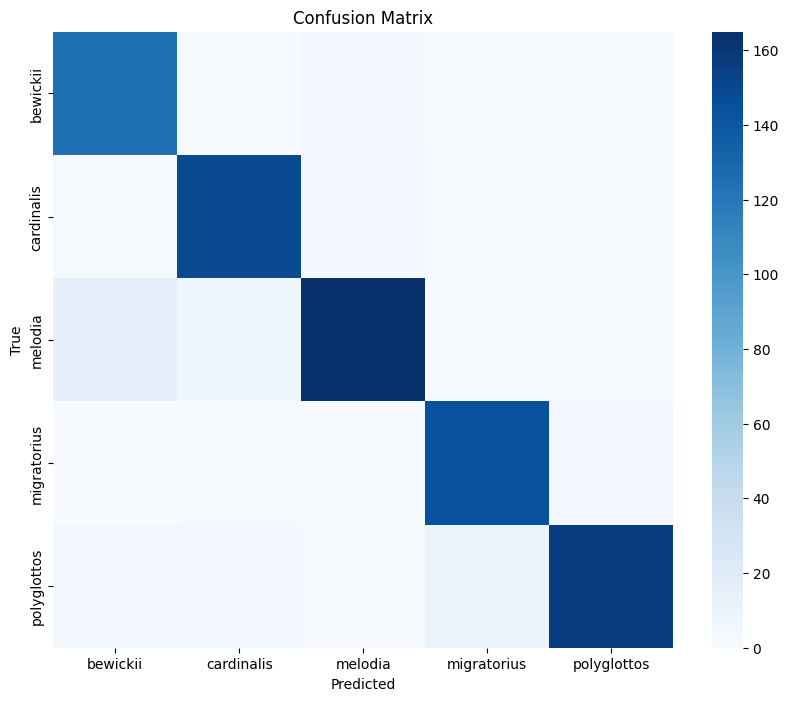

In [29]:
from sklearn.metrics import confusion_matrix, classification_report
import seaborn as sns
import matplotlib.pyplot as plt

y_pred = model.predict(X_test)
y_pred_classes = np.argmax(y_pred, axis=1)
y_true = np.argmax(y_test, axis=1)

print(classification_report(y_true, y_pred_classes, target_names=le.classes_))

cm = confusion_matrix(y_true, y_pred_classes)
plt.figure(figsize=(10, 8))
sns.heatmap(cm, annot=False, cmap="Blues", xticklabels=le.classes_, yticklabels=le.classes_)
plt.xlabel("Predicted")
plt.ylabel("True")
plt.title("Confusion Matrix")
plt.show()


Saving xc553403-bewicks-wren-thryomanes-bewickii_M74f1fI2.mp3 to xc553403-bewicks-wren-thryomanes-bewickii_M74f1fI2.mp3
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 43ms/step


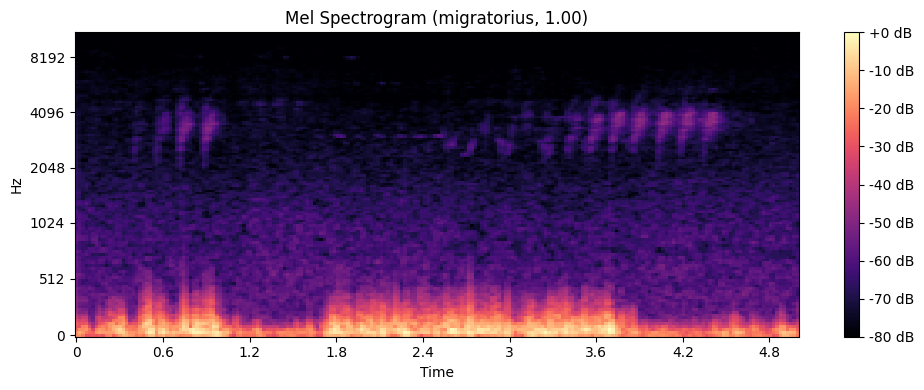

Predicted Species: migratorius, Confidence: 1.00


In [32]:
from google.colab import files
import librosa.display
import matplotlib.pyplot as plt

# Function to predict bird species and generate Mel spectrogram
def predict_bird(file_path, model, le, sr=22050, duration=5):
    # Load and pad/trim audio
    y, _ = librosa.load(file_path, sr=sr, duration=duration, mono=True)
    if len(y) < sr*duration:
        y = np.pad(y, (0, sr*duration - len(y)))
    else:
        y = y[:sr*duration]

    # Extract Mel spectrogram
    mel_spec = librosa.feature.melspectrogram(y=y, sr=sr, n_mels=128, hop_length=512)
    mel_spec_db = librosa.power_to_db(mel_spec, ref=np.max)
    mel_spec_norm = (mel_spec_db - mel_spec_db.min()) / (mel_spec_db.max() - mel_spec_db.min())
    mel_spec_norm = mel_spec_norm[:, :216]  # Fix time frames
    mel_spec_norm = mel_spec_norm[np.newaxis, ..., np.newaxis]  # Add batch + channel

    # Prediction
    prediction = model.predict(mel_spec_norm)
    predicted_class = np.argmax(prediction, axis=1)[0]
    species = le.classes_[predicted_class]
    confidence = prediction[0][predicted_class]

    # Show Mel spectrogram
    plt.figure(figsize=(10, 4))
    librosa.display.specshow(mel_spec_db, sr=sr, hop_length=512, x_axis='time', y_axis='mel')
    plt.colorbar(format='%+2.0f dB')
    plt.title(f"Mel Spectrogram ({species}, {confidence:.2f})")
    plt.tight_layout()
    plt.show()

    return species, confidence


# ---- Upload and predict ----
uploaded = files.upload()  # Upload .wav file

for fn in uploaded.keys():
    file_path = fn
    species, confidence = predict_bird(file_path, model, le)
    print(f"Predicted Species: {species}, Confidence: {confidence:.2f}")


In [33]:
from google.colab import files
files.download("bird_model.h5")


<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>